In [3]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [22]:
from torchinfo import summary
from collections import OrderedDict
from networks.INR import INR
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import torchvision
import torch
import os

from data.DWSNets_dataset import DWSNetsDataset, TokenTransform, LayerOneHotTransform, FlattenTransform, BiasFlagTransform, PositionEncodingTransform, MinMaxTransformer
from networks.naive_rq_ae import RQAutoencoder, RQAutoencoderConfig
from networks.nano_gpt import GPTConfig
from training.training_nano_gpt import train as train_gpt, Config as TrainConfig

In [54]:

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

# class AutoencoderTransform(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.bias = BiasFlagTransform()
#     self.flatten = FlattenTransform()
#     self.layer_one_hot = LayerOneHotTransform()

#   def forward(self, x, y):
#     bias, _ = self.bias(x, y)
#     layer, _ = self.layer_one_hot(x, y)    
#     x, _ = self.flatten(x, y)
#     return torch.hstack((x, layer, bias)), y
  

class AutoencoderTransform2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = FlattenTransform()
    self.minmax = MinMaxTransformer()

  def forward(self, x, y):
    x, _ = self.flatten(x, y)
    x, _ = self.minmax(x, y)
    return x, y

class UnwrapXTransform(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = FlattenTransform()

  def forward(self, x, y):
    x, y = self.flatten(x, y)
    return x

transform = torchvision.transforms.Compose([FlattenTransform(), UnwrapXTransform()])

dataset_no_transform = DWSNetsDataset(data_root)
dataset_flatten = DWSNetsDataset(data_root, transform=UnwrapXTransform())
dataset_test_flatten = DWSNetsDataset(data_root, split="test", transform=FlattenTransform())

# train_dataset = DWSNetsDataset(data_root, transform=AutoencoderTransform2())
# test_dataset = DWSNetsDataset(data_root, split="test", transform=AutoencoderTransform2())


1185

In [56]:
weights_dim = dataset_flatten[0].numel()

ae_config = RQAutoencoderConfig(dim_enc=(weights_dim, 512), dim_dec=(512, weights_dim), activation=torch.nn.Tanh(), codebook_size=2 ^ 10)
ae = RQAutoencoder(ae_config)
summary(ae, input_size=(16, weights_dim))

Layer (type:depth-idx)                        Output Shape              Param #
RQAutoencoder                                 [16, 1185]                --
├─Sequential: 1-1                             [16, 512]                 --
│    └─Linear: 2-1                            [16, 512]                 607,232
├─ResidualVQ: 1-2                             [16, 512]                 --
│    └─Identity: 2-2                          [16, 512]                 --
│    └─ModuleList: 2-3                        --                        --
│    │    └─VectorQuantize: 3-1               [16, 512]                 --
│    │    └─VectorQuantize: 3-20              --                        --
│    │    └─VectorQuantize: 3-3               --                        --
│    │    └─VectorQuantize: 3-4               [16, 512]                 --
│    │    └─VectorQuantize: 3-20              --                        --
│    │    └─VectorQuantize: 3-6               --                        --
│    │    └─Vec

In [49]:
len_training_data = 1000
training_data = []
for i in range(len_training_data):
  training_data.append(dataset_flatten[i][0])


In [62]:
dataset_flatten[0]

tensor([-0.0903,  0.0274, -0.0345,  ..., -0.0466, -0.0766, -0.1869])

In [96]:
from training.training_autoencoder import train_model, TrainingConfig

from torch import nn
from torch.nn import MSELoss, CrossEntropyLoss, L1Loss
from torch.utils.data import DataLoader


batch_size = 4
train_dataloader = DataLoader(dataset_flatten[0].unsqueeze(0), batch_size=batch_size, shuffle=True)
test_dataloader = train_dataloader#DataLoader([test_dataset[0][0][0]], batch_size=1, shuffle=True)

train_config = TrainingConfig()
train_config.max_iters = 50
train_config.always_save_checkpoint = True
train_config.weight_decay = 0.0
train_config.learning_rate = 1e-3
train_config.lr_decay_iters = int(train_config.max_iters*result.size()[0]/batch_size)
train_config.warmup_iters = int(0.1*train_config.max_iters*result.size()[0]/batch_size)
train_config.log_interval = 1

# class AutoencoderLoss(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.mse = L1Loss()
#     self.ce = CrossEntropyLoss()

#   def forward(self, pred, true):
#     # take first column of pred and true and compare them with mse
#     x_pred = pred[:, :1]
#     x_true = true[:, :1]

#     mse_loss = self.mse(x_pred, x_true)


#     # compare one hot encoding (eg feature 1, 2, 3) with cross entropy loss
#     layer_pred = pred[:, 1:4]
#     layer_true = true[:, 1:4]
#     ce_loss = self.ce(layer_pred, layer_true)

#     # compare bias flag
#     bias_pred = pred[:, 4]
#     bias_true = true[:, 4]
#     bias_loss = self.ce(bias_pred, bias_true)

#     return mse_loss + ce_loss + bias_loss

ae_trained = train_model(train_config, ae_config, train_dataloader, test_dataloader, L1Loss())

wandb: Network error (ConnectionError), entering retry loop.
wandb: ERROR Control-C detected -- Run data was not synced


Problem at: /Users/luca/uni/master/second-semester/adl4cv/.venv/lib/python3.12/site-packages/wandb/sdk/wandb_init.py 849 getcaller


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [30]:
from data.DWSNets_dataset import TokenTransform


#tokenTransform = TokenTransform(ae_trained)#
#tokenTransform.forward(dataset_flatten[0][0], dataset_flatten[0][1])

In [65]:
if True:
  PATH = "./models/model_epoch_0.pth"
  ae_trained = RQAutoencoder(ae_config)
  ae_trained.load_state_dict(torch.load(PATH)["model_state_dict"])


Transformed Weights: tensor([0.5351, 0.6517, 0.7683, 0.8850])
64
torch.Size([64])
32
torch.Size([32])
1024
torch.Size([1024])
32
torch.Size([32])
32
torch.Size([32])
1
torch.Size([1])


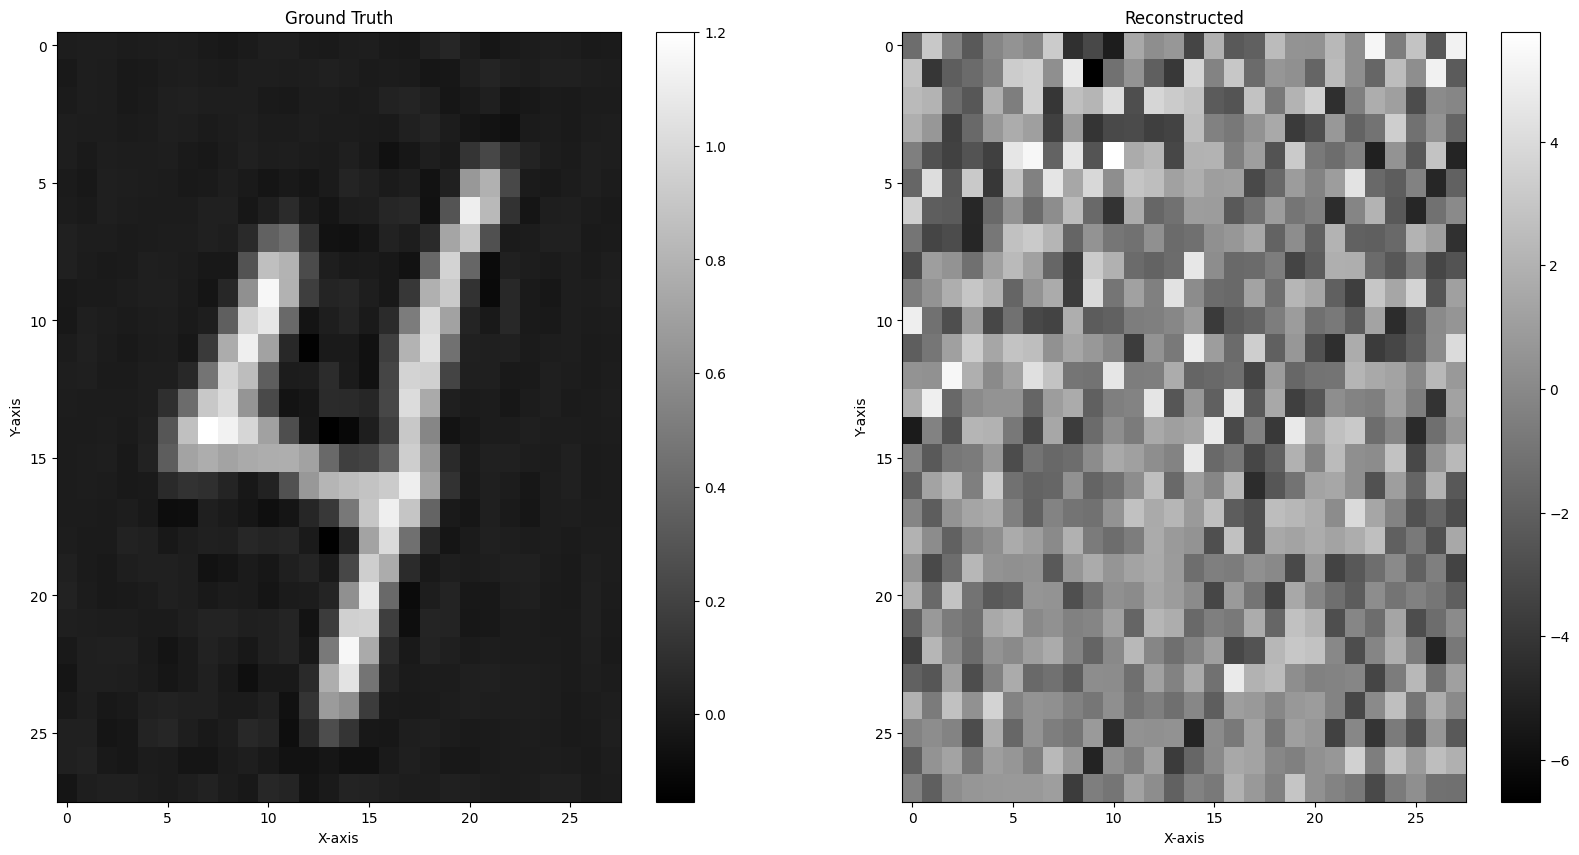

In [93]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import OrderedDict
from typing import List, Tuple, Union

# Assuming the following classes and functions are defined elsewhere:
# - INR
# - dataset_no_transform
# - ae_trained
# - dataset_flatten


class MinMaxTransformer(nn.Module):
    def __init__(self, min_value: float = -0.3587, max_value: float = 0.4986):
        super().__init__()
        self.min_value = min_value
        self.max_value = max_value

    def forward(self, weights, y):
        # Apply min-max normalization
        weights = (weights - self.min_value) / (self.max_value - self.min_value)
        return weights, y

    def reverse(self, normalized_weights):
        # Reverse the min-max normalization
        original_weights = normalized_weights * (self.max_value - self.min_value) + self.min_value
        return original_weights

# Example usage:
minmax_transformer = MinMaxTransformer(min_value=-0.3587, max_value=0.4986)
weights = torch.tensor([0.1, 0.2, 0.3, 0.4])
y = torch.tensor([1.0])  # Example target

# Transform the weights
transformed_weights, transformed_y = minmax_transformer(weights, y)
print("Transformed Weights:", transformed_weights)

def backtransform_weights(flattened_weights, original_weights_dict):
    reconstructed_dict = OrderedDict()
    start = 0
    for key, tensor in original_weights_dict.items():
        num_elements = tensor.numel()
        print(num_elements)
        flattened_slice = flattened_weights[0, start:start + num_elements]
        print(flattened_slice.shape)
        reconstructed_tensor = flattened_slice.view(tensor.shape)
        reconstructed_dict[key] = reconstructed_tensor
        start += num_elements
    return reconstructed_dict

def make_coordinates(
    shape: Union[Tuple[int], List[int]],
    bs: int,
    coord_range: Union[Tuple[int], List[int]] = (-1, 1),
) -> torch.Tensor:
    x_coordinates = np.linspace(coord_range[0], coord_range[1], shape[0])
    y_coordinates = np.linspace(coord_range[0], coord_range[1], shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    coordinates = np.stack([x_coordinates, y_coordinates]).T
    coordinates = np.repeat(coordinates[np.newaxis, ...], bs, axis=0)
    return torch.from_numpy(coordinates).type(torch.float)

# Configuration
inr_kwargs = {"n_layers": 3, "in_dim": 2, "up_scale": 16}
image_size = (28, 28)
idx = 0
# Get dataset elements
dataset_ele = dataset_no_transform[idx][0]
minmax_transformer = MinMaxTransformer(min_value=-0.3587, max_value=0.4986)
dataset_ele_flattened = minmax_transformer.reverse(ae_trained(dataset_flatten[idx].unsqueeze(0)))

# Backtransform weights
reconstructed_dict = backtransform_weights(dataset_ele_flattened, dataset_ele)

# Initialize and load the INR model
inr = INR(**inr_kwargs)
inr.load_state_dict(reconstructed_dict)
inr.eval()

# Generate image using the INR model
input_coords = make_coordinates(image_size, 1)
with torch.no_grad():
    reconstructed_image = inr(input_coords)
    reconstructed_image = reconstructed_image.view(*image_size, -1)
    reconstructed_image = reconstructed_image.permute(2, 0, 1)

reconstructed_tensor = reconstructed_image.squeeze(0)

# Load ground truth model
ground_truth_dict = dataset_ele
ground_truth_inr = INR(**inr_kwargs)
ground_truth_inr.load_state_dict(ground_truth_dict)
ground_truth_inr.eval()

# Generate image using the ground truth model
with torch.no_grad():
    ground_truth_image = ground_truth_inr(input_coords)
    ground_truth_image = ground_truth_image.view(*image_size, -1)
    ground_truth_image = ground_truth_image.permute(2, 0, 1)

ground_truth_tensor = ground_truth_image.squeeze(0)

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto')
axes[1].set_title('Reconstructed')
axes[1].set_xlabel('X-axis')
axes[1].set_ylabel('Y-axis')

plt.colorbar(axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto'), ax=axes[0])
plt.colorbar(axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto'), ax=axes[1])
plt.show()


In [32]:
gpt_config = GPTConfig()
train_config = TrainConfig()
train_config.batch_size = 1

gpt_train_dataset = DWSNetsDataset(data_root, transform=TokenTransform(ae_trained))
gpt_test_dataset = DWSNetsDataset(data_root, split="test", transform=TokenTransform(ae_trained))

gpt_train_dataloader = DataLoader([gpt_train_dataset[0]], batch_size=train_config.batch_size, shuffle=True)
gpt_test_dataloader = DataLoader([gpt_train_dataset[0]], batch_size=train_config.batch_size, shuffle=True)



def get_batch(split: str):
    if split == "train":
        return next(gpt_train_dataset)
    elif split == "test":
        return next(gpt_test_dataset)
    else:
        raise ValueError(f"Invalid split: {split}")

train_gpt(get_batch, train_config, gpt_config)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

tensor([[0.4137],
        [0.4537],
        [0.4627],
        ...,
        [0.2655],
        [0.5721],
        [0.2031]])

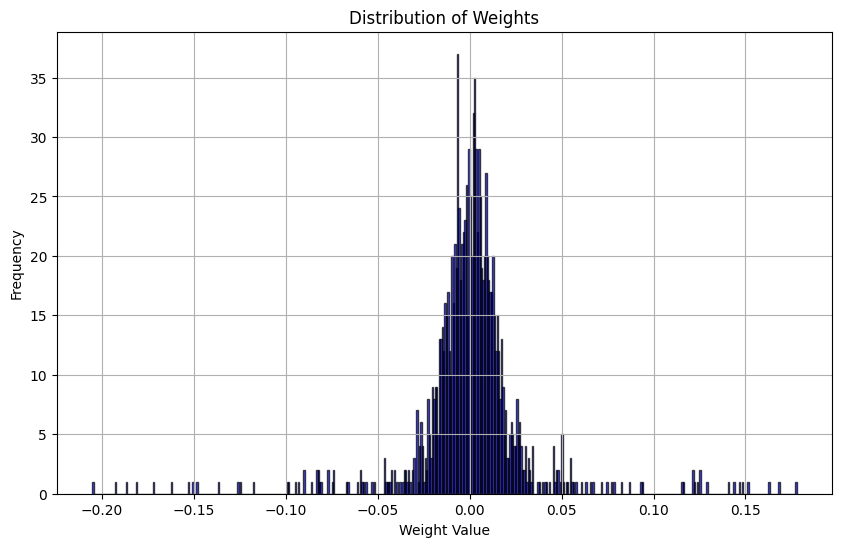

In [85]:
import torch
import matplotlib.pyplot as plt

# Example tensor of weights
weights = dataset_flatten[idx]
# Convert the tensor to a 1D array
weights_1d = weights.view(-1).numpy()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(weights_1d, bins=500, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

target_x = weights_1d

In [74]:
dataset_flatten[0].shape

torch.Size([1185])

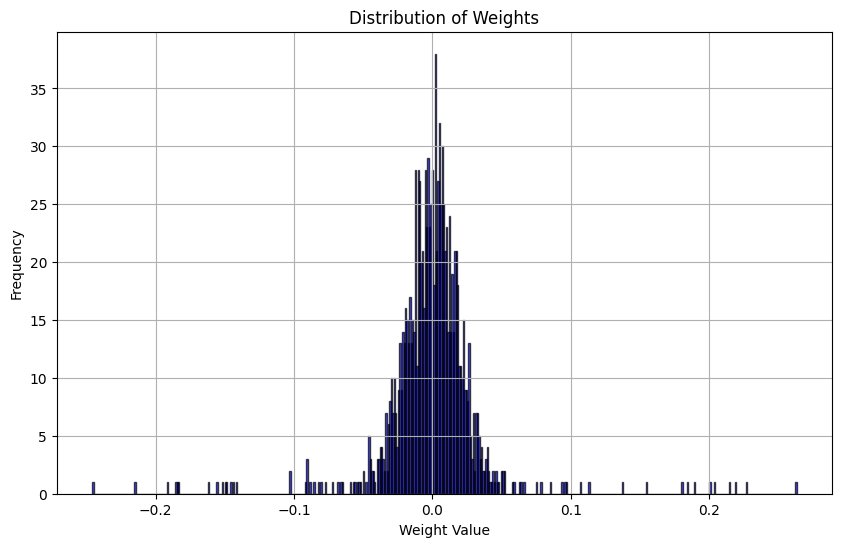

wandb: Network error (ConnectionError), entering retry loop.


In [94]:
import torch
import matplotlib.pyplot as plt

# Example tensor of weights
with torch.no_grad():
    weights = ae_trained(dataset_flatten[idx].unsqueeze(0)).squeeze(0)
    

    # Convert the tensor to a 1D array´
    weights_1d = weights.numpy()
    pred_x = weights_1d

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(weights_1d, bins=500, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [23]:
dataset = MnistNeFDataset(data_root_ours)
dataset[-1]

({'state_dict': OrderedDict([('layers.0.weight',
                tensor([[ 4.4664e-01, -4.3010e-01, -2.5178e-01, -5.7684e-01, -1.7243e-02,
                          6.8038e-01,  3.9131e-02, -8.4039e-01, -1.2045e-01,  7.5996e-01,
                         -6.6085e-01, -1.6679e-01, -6.4688e-01,  8.0170e-01, -5.8400e-01,
                          7.8356e-01, -1.4730e-01,  1.0996e+00],
                        [ 1.4678e-01, -2.7001e-01, -3.8589e-01, -4.4566e-01,  3.1697e-01,
                          5.8387e-01,  1.4595e-01,  1.4363e-01,  4.1224e-01,  2.1473e-01,
                          3.0856e-01,  7.4236e-01, -5.7107e-01, -3.1331e-01, -4.2761e-01,
                         -1.0635e+00,  8.0378e-02, -3.6832e-01],
                        [ 4.8115e-02,  6.2005e-01,  7.3046e-01, -1.5464e-01,  3.0089e-01,
                         -2.0732e-01, -6.7381e-02,  1.6518e-01, -2.1270e-01,  5.1692e-01,
                         -3.8728e-01,  7.4999e-01, -5.5869e-02,  2.1801e-01, -1.6073e-01,
           

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_85857/2310941086.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ref_point[0], closest_point[0]], [ref_point[1], closest_point[1]], 'k--', color='white', alpha=0.5)


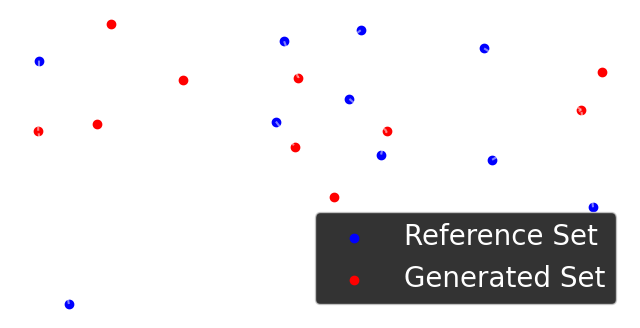

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

plt.style.use("dark_background")

# Generate random reference and generated sets
np.random.seed(0)
reference_set = np.random.rand(10, 2)
generated_set = np.random.rand(10, 2)

# Create a scatter plot
fig = plt.figure(figsize=(8, 4))

# scale y axis to figsize
reference_set[:, 1] *= 4 / 8
generated_set[:, 1] *= 4 / 8

fig.set_facecolor('none')

plt.scatter(reference_set[:, 0], reference_set[:, 1], c='blue', label='Reference Set')
plt.scatter(generated_set[:, 0], generated_set[:, 1], c='red', label='Generated Set')

# Find and draw lines to the closest points
for ref_point in reference_set:
    distances = distance.cdist([ref_point], generated_set, 'euclidean')
    closest_index = np.argmin(distances)
    closest_point = generated_set[closest_index]
    plt.plot([ref_point[0], closest_point[0]], [ref_point[1], closest_point[1]], 'k--', color='white', alpha=0.5)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis("off")
plt.rc('legend', fontsize=20)    # legend fontsize
plt.legend()
plt.grid(True)
plt.show()

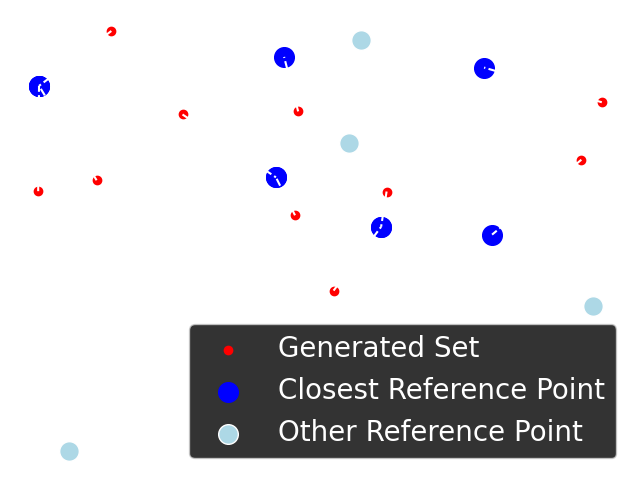

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

# Generate random reference and generated sets
np.random.seed(0)
reference_set = np.random.rand(10, 2)
generated_set = np.random.rand(10, 2)

# Create a scatter plot
fig = plt.figure(figsize=(8, 6))

fig.set_facecolor('none')


# scale y axis to figsize
reference_set[:, 1] *= 6 / 8
generated_set[:, 1] *= 6 / 8

plt.scatter(generated_set[:, 0], generated_set[:, 1], c='red', label='Generated Set')

# for every generated point, find the closest reference point
closest_reference_indices = set()
for gen_point in generated_set:
    distances = distance.cdist([gen_point], reference_set, 'euclidean')
    closest_index = np.argmin(distances)

    # highlight the closest reference point
    plt.scatter(reference_set[closest_index, 0], reference_set[closest_index, 1], c='blue', s=200, label="Closest Reference Point" if len(closest_reference_indices) == 0 else None)

    # draw a line between the generated point and the closest reference point
    closest_point = reference_set[closest_index]
    plt.plot([gen_point[0], closest_point[0]], [gen_point[1], closest_point[1]], color='white', linestyle='--')
    closest_reference_indices.add(closest_index)

# Draw all other reference points
# eg. the ones that are not in the closest_reference_indices
for idx, ref_point in enumerate(reference_set):
    if idx not in closest_reference_indices:
        plt.scatter(ref_point[0], ref_point[1], c='lightblue', edgecolor='white', s=200, label="Other Reference Point" if idx == 0 else None)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis("off")
plt.legend()
plt.grid(True)
plt.show()
